In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img


# Set up paths (make sure to adjust this to your directory)
base_dir = 'D:/Dataset/archive (5)/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Image Data Generator for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation, we don’t augment; only rescale
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load data using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [3]:
# We are goin to use CNN as a basic model as first level of project 
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# # Initialize the CNN
# model = Sequential()

# # Convolutional Layer 1
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Adjust input shape as needed
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Convolutional Layer 2
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Convolutional Layer 3
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flattening
# model.add(Flatten())

# # Fully Connected Layer
# model.add(Dense(units=128, activation='relu'))
# model.add(Dropout(0.5))  # Dropout to reduce overfitting

# # Output Layer
# model.add(Dense(units=1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# # Compile the Model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the Model Summary
# model.summary()
# This model gives around 68% of accuracy


In [4]:
#VGG16 Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10  # Adjust as needed
)

#Id we use thia model we get 87.5% Accuracy


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [5]:
# # Train the Model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size,
#     epochs=10  # Adjust the number of epochs as needed
# )


In [6]:
print(history.history.keys())


dict_keys(['loss', 'accuracy'])


In [7]:
# Evaluating the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")


1/1 [==============================] - 2s 2s/step - loss: 0.2371 - accuracy: 0.8750
Validation Loss: 0.23714834451675415, Validation Accuracy: 0.875


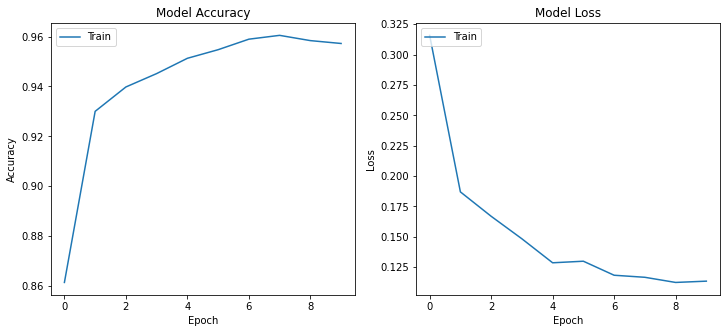

In [10]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1/1 [==============================] - 0s 122ms/step
Prediction: Normal (Confidence: 0.03)


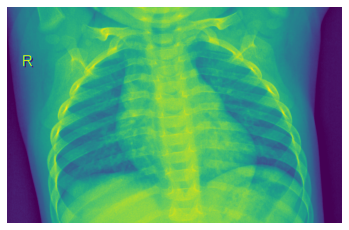

In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    class_label = 'Pneumonia' if prediction[0][0] > 0.5 else 'Normal'
    print(f'Prediction: {class_label} (Confidence: {prediction[0][0]:.2f})')

# Example usage
predict_image("D:/Dataset/archive (5)/chest_xray/test/NORMAL/IM-0059-0001.jpeg")

img = mpimg.imread("D:/Dataset/archive (5)/chest_xray/test/NORMAL/IM-0059-0001.jpeg")
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()



In [12]:
model.save('pneumonia_detection_model.h5')


In [13]:
from tensorflow.keras.models import load_model

loaded_model = load_model('pneumonia_detection_model.h5')


In [ ]:
# Setting up with DensenNet121 Model

In [22]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load DenseNet121 pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model initially
base_model.trainable = False

# Add custom layers on top of DenseNet121
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


29084464/29084464 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [23]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
163/163 [==============================] - 257s 2s/step - loss: 0.3519 - accuracy: 0.8426 - lr: 1.0000e-04
Epoch 2/20
163/163 [==============================] - 224s 1s/step - loss: 0.2132 - accuracy: 0.9156 - lr: 1.0000e-04
Epoch 3/20
163/163 [==============================] - 255s 2s/step - loss: 0.1884 - accuracy: 0.9256 - lr: 1.0000e-04
Epoch 4/20
163/163 [==============================] - 226s 1s/step - loss: 0.1743 - accuracy: 0.9331 - lr: 1.0000e-04
Epoch 5/20
163/163 [==============================] - 32449s 200s/step - loss: 0.1552 - accuracy: 0.9421 - lr: 1.0000e-04
Epoch 6/20
163/163 [==============================] - 11248s 69s/step - loss: 0.1516 - accuracy: 0.9425 - lr: 1.0000e-04
Epoch 7/20
163/163 [==============================] - 266s 2s/step - loss: 0.1500 - accuracy: 0.9417 - lr: 1.0000e-04
Epoch 8/20
163/163 [==============================] - 318s 2s/step - loss: 0.1435 - accuracy: 0.9436 - lr: 1.0000e-04
Epoch 9/20
163/163 [=============================

In [24]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/10
163/163 [==============================] - 254s 2s/step - loss: 0.1311 - accuracy: 0.9479 - lr: 1.0000e-05
Epoch 3/10
163/163 [==============================] - 237s 1s/step - loss: 0.1268 - accuracy: 0.9517 - lr: 1.0000e-05
Epoch 4/10
163/163 [==============================] - 238s 1s/step - loss: 0.1192 - accuracy: 0.9571 - lr: 1.0000e-05
Epoch 5/10
163/163 [==============================] - 234s 1s/step - loss: 0.1227 - accuracy: 0.9525 - lr: 1.0000e-05
Epoch 6/10
163/163 [==============================] - 232s 1s/step - loss: 0.1087 - accuracy: 0.9601 - lr: 1.0000e-05
Epoch 7/10
163/163 [==============================] - 230s 1s/step - loss: 0.1033 - accuracy: 0.9599 - lr: 1.0000e-05
Epoch 8/10
163/163 [==============================] - 230s 1s/step - loss: 0.1062 - accuracy: 0.9590 - lr: 1.0000e-05
Epoch 9/10
163/163 [==============================] - 232s 1s/step - loss: 0.0989 - accuracy: 0.9618 - lr: 1.0000e-05
Epoch 10/10
163/163 [==============================] - 2

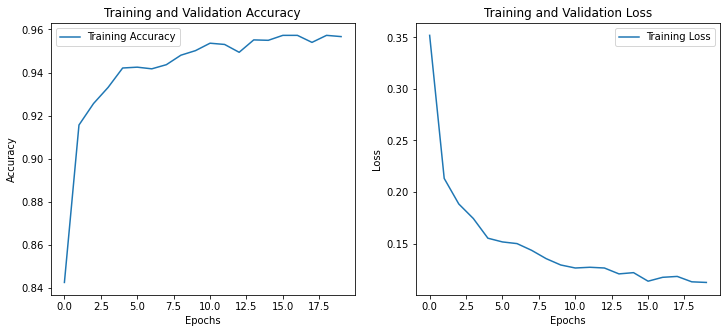

In [27]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


1/1 [==============================] - 1s 1s/step
Prediction: Normal (Confidence: 0.00)


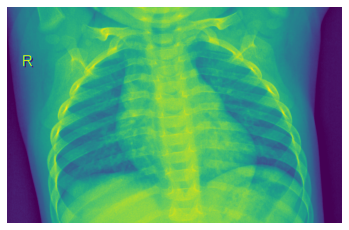

In [28]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    class_label = 'Pneumonia' if prediction[0][0] > 0.5 else 'Normal'
    print(f'Prediction: {class_label} (Confidence: {prediction[0][0]:.2f})')

# Example usage
predict_image("D:/Dataset/archive (5)/chest_xray/test/NORMAL/IM-0059-0001.jpeg")

img = mpimg.imread("D:/Dataset/archive (5)/chest_xray/test/NORMAL/IM-0059-0001.jpeg")
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()



In [29]:
model.save('pneumonia_detection_model.h5')